# Predicción de respuesta a campaña de marketing bancario

En este proyecto utilizamos datos de una campaña de marketing directo de una entidad bancaria.
El objetivo es **predecir si un cliente contratará un depósito a plazo fijo** (`y` = "yes" / "no")
a partir de información sociodemográfica, financiera y del propio proceso de contacto comercial.

Trabajam con un modelo de **Regresión Logística**, adecuado para problemas de clasificación binaria,
y seguiremos el flujo:

1. Exploración y limpieza de datos.
2. Análisis exploratorio (EDA) univariante, bivariante y multivariante.
3. Preparación de datos para modelado (encoding + escalado).
4. Entrenamiento y ajuste de un modelo de Regresión Logística.
5. Evaluación del modelo y conclusiones de negocio.

## 1. Importar librerias

In [365]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pickle
from pickle import dump
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split

os.makedirs("../models", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)


RANDOM_STATE = 16
pd.set_option('display.max_columns', 200)

## 2. Carga de datos y limpieza inicial

En esta sección cargamos el dataset original y realizamos una primera revisión de:

- Dimensiones del dataset.
- Tipos de variables.
- Valores nulos y duplicados.

Adicionalmente, eliminamos algunas columnas que no utilizaremos en el modelo
(por ejemplo, `duration`, `emp.var.rate` y `nr.employed`), siguiendo las recomendaciones del profesor
y la documentación del dataset.

In [366]:
url = "https://storage.googleapis.com/breathecode/project-files/bank-marketing-campaign-data.csv"
df = pd.read_csv(url, sep=';')

print('El dataframe contiene {} lineas y {} features.'.format(len(df), df.shape[1]))
print(df.columns)
df.head(5)

El dataframe contiene 41188 lineas y 21 features.
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Resumen de columnas:

- age. Edad del cliente (numérico)
- campaign. Número de contactos realizados durante esta campaña al cliente (numérico)
- pdays. Número de días que transcurrieron desde la última campaña hasta que fue contactado (numérico)
- previous. Número de contactos realizados durante la campaña anterior al cliente (numérico)
- cons.price.idx. Índice de precios al consumidor. Indicador mensual (numérico) "aumento de coste de la vida"
- cons.conf.idx. Índice de confianza del consumidor. Indicador mensual (numérico) "opinion situacioin fininanciera del pais"
- euribor3m. Tasa EURIBOR 3 meses. Indicador diario (numérico)
- job. Tipo de trabajo (categórico)
- marital. Estado civil (categórico)
- education. Nivel de educación (categórico)
- default. ¿Tiene crédito actualmente? (categórico)
- housing. ¿Tiene un préstamo de vivienda? (categórico)
- loan. ¿Tiene un préstamo personal? (categórico)
- contact. Tipo de comunicación de contacto (categórico)
- month. Último mes en el que se le ha contactado (categórico)
- day_of_week. Último día en el que se le ha contactado (categórico)
- poutcome. Resultado de la campaña de marketing anterior (categórico)
- y. TARGET. El cliente contrata un depósito a largo plazo o no (categórico)

- duration. Duración del contacto previo en segundos (numérico)
- emp.var.rate. Tasa de variación del empleo. Indicador trimestral (numérico)
- nr.employed. Número de empleados. Indicador trimestral (numérico)

In [367]:
print(f"Dimensiones del dataframe: {df.shape}")
print(df.info())

Dimensiones del dataframe: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float

In [368]:
print(f"Valores unicos por columna: \n{df.nunique()}")

Valores unicos por columna: 
age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64


In [369]:
# Conteo de valores nulos

print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [370]:
dups = df.duplicated().sum()
print("Duplicados:", dups)

Duplicados: 12


In [371]:
nulls = df.isna().mean().sort_values(ascending=False)
nulls.head(10)

age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
dtype: float64

In [372]:
# Estadísticas descriptivas de columnas numéricas

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


### 2.1 Limpieza inicial del dataset

En esta parte eliminamos las columnas que no aportan valor al análisis o al modelado.

In [373]:
# Creamos una copia del dataframe para realizar el análisis exploratorio de datos (EDA) sin modificar el original

df_eda = df.copy()

# Columnas poco útiles para un modelo de precio (identificadores, texto libre, fechas)

cols_to_drop = ['duration', 'emp.var.rate', 'nr.employed']

print("Shape antes del drop:", df_eda.shape)

df_eda = df_eda.drop(columns=cols_to_drop)

print("Shape después del drop:", df_eda.shape)
print("Columnas restantes:", list(df_eda.columns))

# Revisar de nuevo nulos tras el drop
print("\nValores nulos por columna (tras drop):")
print(df_eda.isnull().sum())

Shape antes del drop: (41188, 21)
Shape después del drop: (41188, 18)
Columnas restantes: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'y']

Valores nulos por columna (tras drop):
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
y                 0
dtype: int64


## 3. Análisis univariante

En esta parte analizamos la distribución de las variables numéricas y categóricas:

- Para **variables numéricas**, utilizamos histogramas y diagramas de caja para detectar asimetrías y posibles outliers.
- Para **variables categóricas**, analizamos la frecuencia de cada categoría y agrupamos en "Otros" cuando el número de niveles es muy elevado.

Esto nos permite entender mejor el perfil predominante de clientes en la base de datos.

### 3.1 Variables numéricas

En esta sección se analiza la distribución individual de cada variable numérica.

- age. Edad del cliente (numérico)
- campaign. Número de contactos realizados durante esta campaña al cliente (numérico)
- pdays. Número de días que transcurrieron desde la última campaña hasta que fue contactado (numérico)
- previous. Número de contactos realizados durante la campaña anterior al cliente (numérico)
- cons.price.idx. Índice de precios al consumidor. Indicador mensual (numérico)
- cons.conf.idx. Índice de confianza del consumidor. Indicador mensual (numérico)
- euribor3m. Tasa EURIBOR 3 meses. Indicador diario (numérico)

Variables numéricas: ['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']


,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045


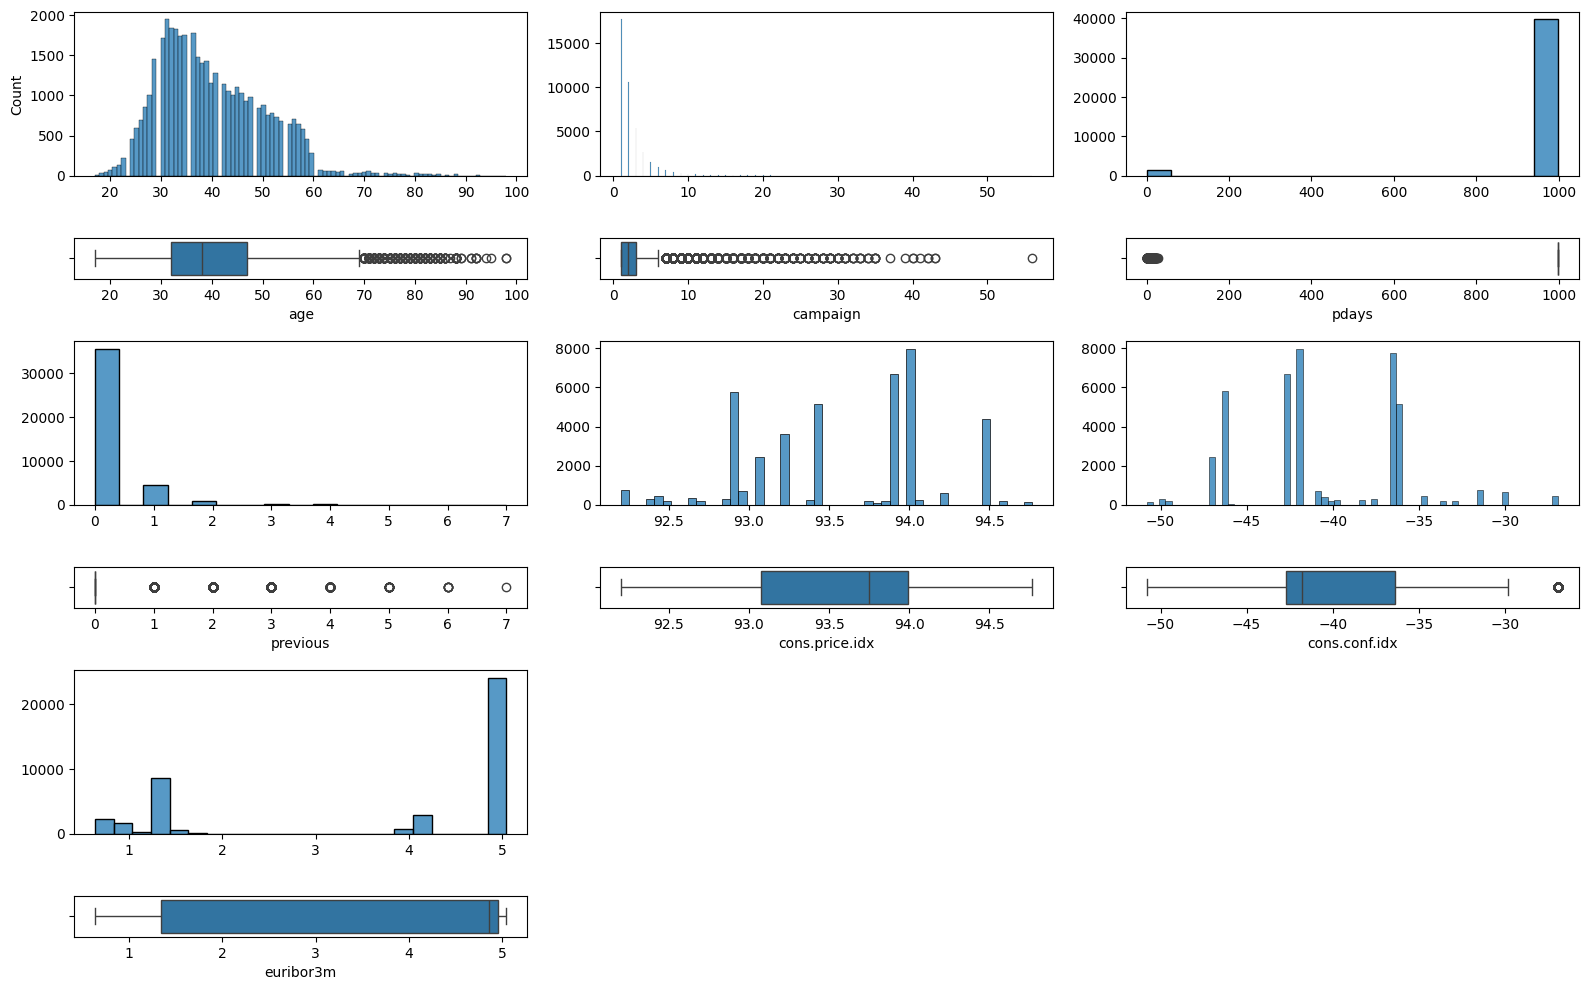

In [374]:
fig, axis = plt.subplots(6, 3, figsize = (16, 10), gridspec_kw={'height_ratios': [4, 1, 4, 1, 4, 1]})

# Selección de variables numéricas
num_cols = df_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Variables numéricas:", num_cols)

# Resumen estadístico
display(df_eda[num_cols].describe().T)

# Crear una figura múltiple con histogramas y diagramas de caja

sns.histplot(ax = axis[0, 0], data = df_eda, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = df_eda, x = "age")

sns.histplot(ax = axis[0, 1], data = df_eda, x = "campaign").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df_eda, x = "campaign")

sns.histplot(ax = axis[0, 2], data = df_eda, x = "pdays").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 2], data = df_eda, x = "pdays")

sns.histplot(ax = axis[2, 0], data = df_eda, x = "previous").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 0], data = df_eda, x = "previous")

sns.histplot(ax = axis[2, 1], data = df_eda, x = "cons.price.idx").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = df_eda, x = "cons.price.idx")

sns.histplot(ax = axis[2, 2], data = df_eda, x = "cons.conf.idx").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 2], data = df_eda, x = "cons.conf.idx")

sns.histplot(ax = axis[4, 0], data = df_eda, x = "euribor3m").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 0], data = df_eda, x = "euribor3m")

fig.delaxes(axis[4, 1])
fig.delaxes(axis[5, 1])

fig.delaxes(axis[4, 2])
fig.delaxes(axis[5, 2])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

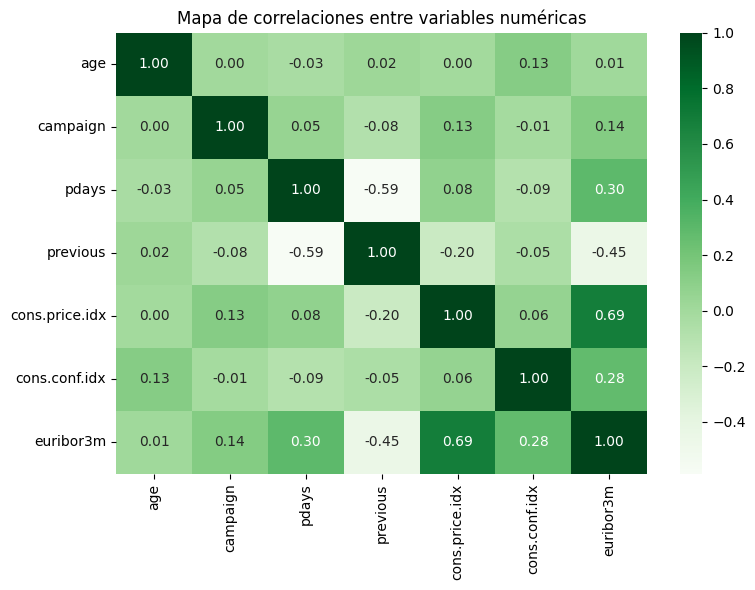

In [375]:
plt.figure(figsize=(8, 6))
corr_num = df_eda[num_cols].corr()

sns.heatmap(corr_num, annot=True, cmap='Greens', fmt=".2f")
plt.title("Mapa de correlaciones entre variables numéricas")
plt.tight_layout()
plt.show()

### 3.2 Variables categóricas

Ahora se analiza la distribución de las variables categóricas.

- job. Tipo de trabajo (categórico)
- marital. Estado civil (categórico)
- education. Nivel de educación (categórico)
- default. ¿Tiene crédito actualmente? (categórico)
- housing. ¿Tiene un préstamo de vivienda? (categórico)
- loan. ¿Tiene un préstamo personal? (categórico)
- contact. Tipo de comunicación de contacto (categórico)
- month. Último mes en el que se le ha contactado (categórico)
- day_of_week. Último día en el que se le ha contactado (categórico)
- poutcome. Resultado de la campaña de marketing anterior (categórico)
- y. TARGET. El cliente contrata un depósito a largo plazo o no (categórico)

Columnas categóricas a analizar: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
'job' tiene 12 categorías -> se muestra top 10 + 'Otros'.


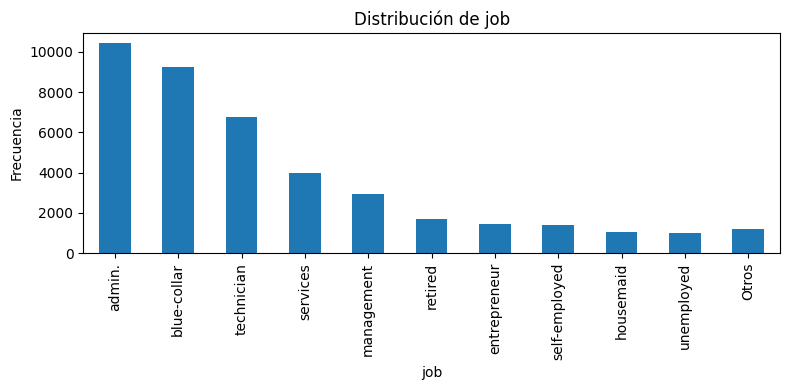

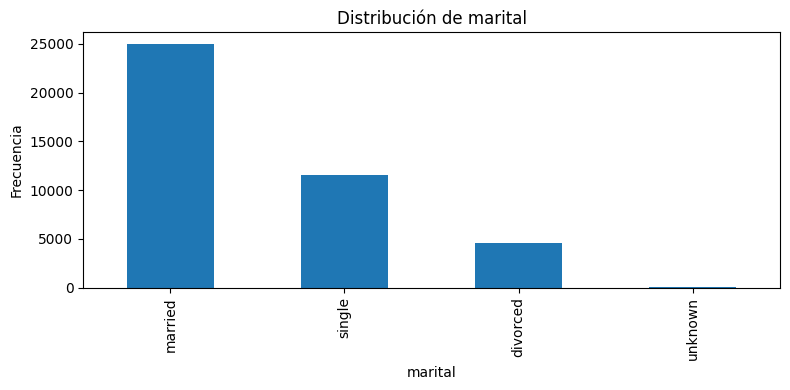

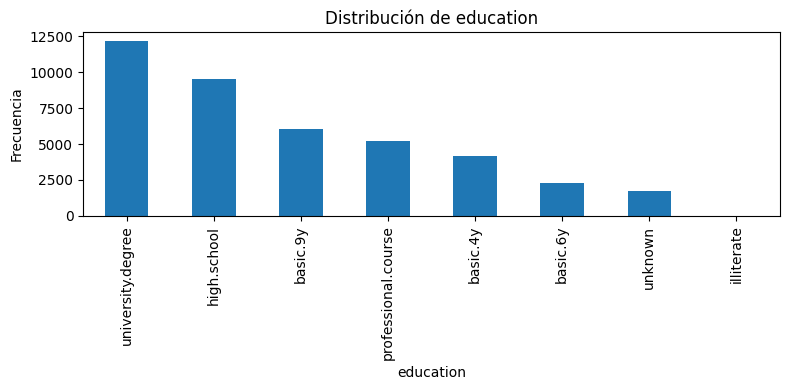

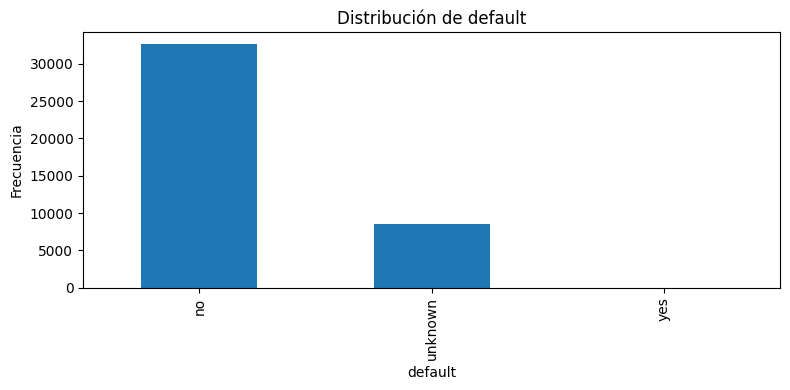

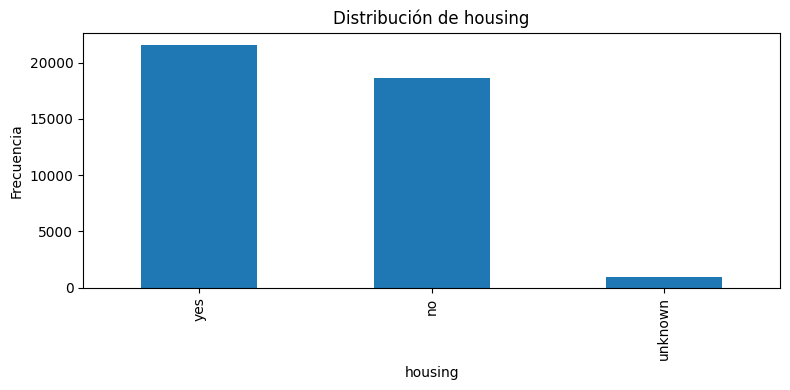

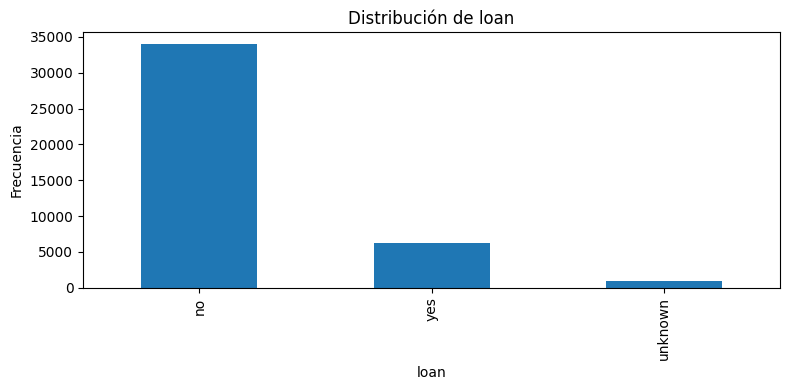

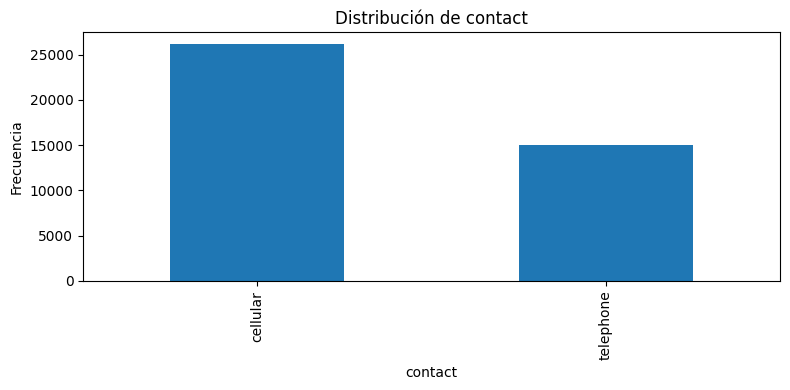

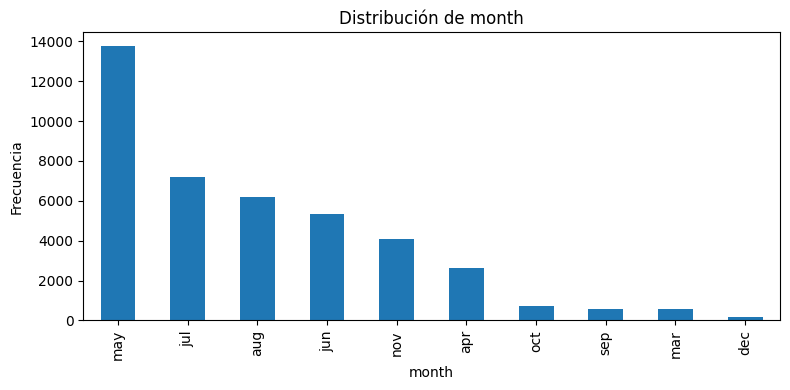

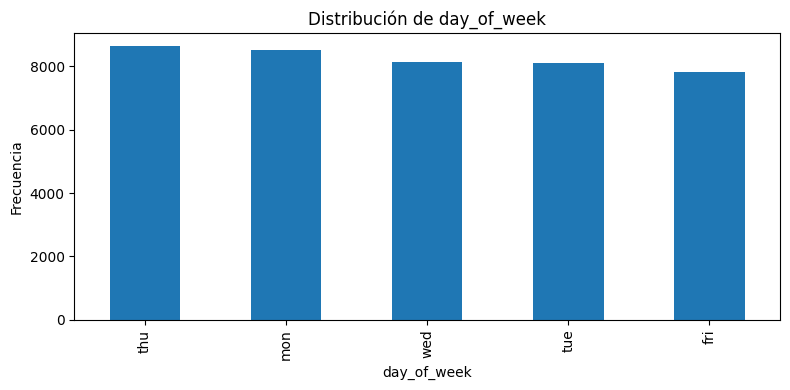

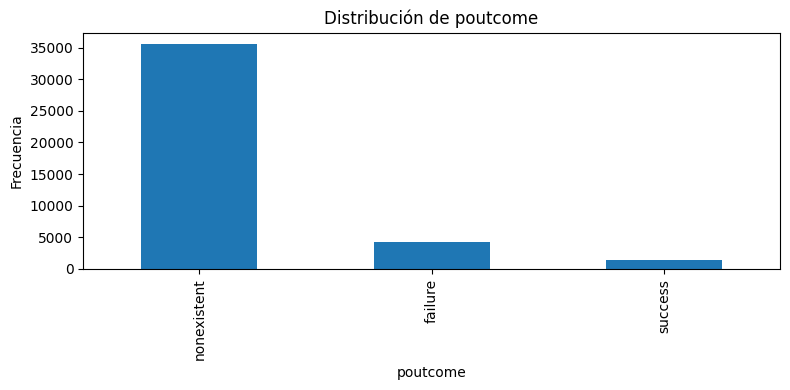

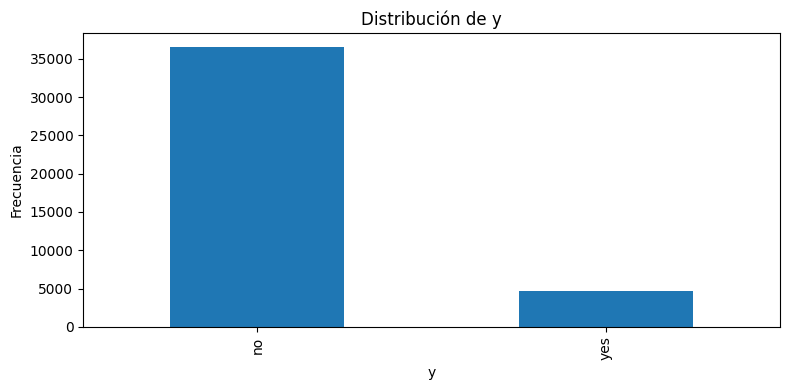

In [376]:
# Seleccionamos columnas categóricas
cat_cols = df_eda.select_dtypes(include=['object']).columns.tolist()
print("Columnas categóricas a analizar:", cat_cols)

for col in cat_cols:
    n_unique = df_eda[col].nunique(dropna=True)

    # Agrupar en "Otros" si hay muchas categorías
    if n_unique > 10:
        print(f"'{col}' tiene {n_unique} categorías -> se muestra top 10 + 'Otros'.")
        top_counts = df_eda[col].value_counts().nlargest(10)
        others_count = df_eda[col].value_counts().iloc[10:].sum()
        counts = pd.concat([top_counts, pd.Series({'Otros': others_count})])
    else:
        counts = df_eda[col].value_counts()

    if counts.size <= 1:
        print(f"Se omite '{col}' (sin variabilidad).")
        continue

    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar')
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

#### 3.3.1 Mapa de correlacion de variables categoricas

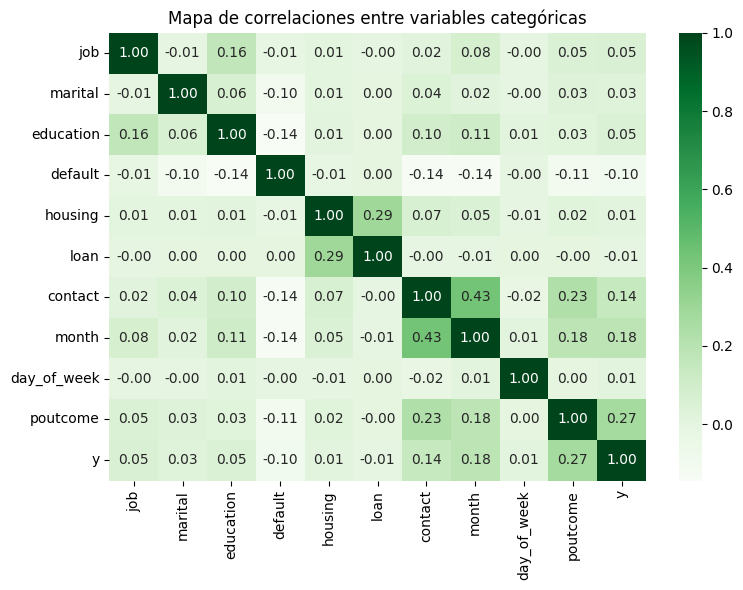

In [377]:
corr_cat = df_eda[cat_cols].apply(lambda x: pd.factorize(x)[0]).corr()

plt.figure(figsize=(8, 6))

sns.heatmap(corr_cat, annot=True, cmap='Greens', fmt=".2f")
plt.title("Mapa de correlaciones entre variables categóricas")
plt.tight_layout()
plt.show()

#### 3.3.2 Factorizar las variables categóricas

In [378]:
total_data = df.copy()
total_data["y_n"] = pd.factorize(total_data.y)[0]


y_transformation_rules = {row["y"]: row["y_n"] for index, row in total_data[["y_n", "y"]].drop_duplicates().iterrows()}
with open("./y_transformation_rules.json", "w") as f:
  json.dump(y_transformation_rules, f)

In [379]:
total_data["job_n"] = pd.factorize(total_data.job)[0]
total_data["education_n"] = pd.factorize(total_data.education)[0]
total_data["marital_n"] = pd.factorize(total_data.marital)[0]
total_data["default_n"] = pd.factorize(total_data.default)[0]
total_data["housing_n"] = pd.factorize(total_data.housing)[0]
total_data["loan_n"] = pd.factorize(total_data.loan)[0]
total_data["contact_n"] = pd.factorize(total_data.contact)[0]
total_data["month_n"] = pd.factorize(total_data.month)[0]
total_data["day_of_week_n"] = pd.factorize(total_data.day_of_week)[0]
total_data["poutcome_n"] = pd.factorize(total_data.poutcome)[0]



job_transformation_rules = {row["job"]: row["job_n"] for index, row in total_data[["job_n", "job"]].drop_duplicates().iterrows()}
with open("./job_transformation_rules.json", "w") as f:
  json.dump(job_transformation_rules, f)

marital_transformation_rules = {row["marital"]: row["marital_n"] for index, row in total_data[["marital_n", "marital"]].drop_duplicates().iterrows()}
with open("./marital_transformation_rules.json", "w") as f:
  json.dump(marital_transformation_rules, f)

education_transformation_rules = {row["education"]: row["education_n"] for index, row in total_data[["education_n", "education"]].drop_duplicates().iterrows()}
with open("./education_transformation_rules.json", "w") as f:
  json.dump(education_transformation_rules, f)

default_transformation_rules = {row["default"]: row["default_n"] for index, row in total_data[["default_n", "default"]].drop_duplicates().iterrows()}
with open("./default_transformation_rules.json", "w") as f:
  json.dump(default_transformation_rules, f)

loan_transformation_rules = {row["loan"]: row["loan_n"] for index, row in total_data[["loan_n", "loan"]].drop_duplicates().iterrows()}
with open("./loan_transformation_rules.json", "w") as f:
  json.dump(loan_transformation_rules, f)

housing_transformation_rules = {row["housing"]: row["housing_n"] for index, row in total_data[["housing_n", "housing"]].drop_duplicates().iterrows()}
with open("./housing_transformation_rules.json", "w") as f:
  json.dump(housing_transformation_rules, f)

contact_transformation_rules = {row["contact"]: row["contact_n"] for index, row in total_data[["contact_n", "contact"]].drop_duplicates().iterrows()}
with open("./contact_transformation_rules.json", "w") as f:
  json.dump(contact_transformation_rules, f)

day_of_week_transformation_rules = {row["day_of_week"]: row["day_of_week_n"] for index, row in total_data[["day_of_week_n", "day_of_week"]].drop_duplicates().iterrows()}
with open("./day_of_week_transformation_rules.json", "w") as f:
  json.dump(day_of_week_transformation_rules, f)

day_of_week_group_transformation_rules = {row["day_of_week"]: row["day_of_week_n"] for index, row in total_data[["day_of_week_n", "day_of_week"]].drop_duplicates().iterrows()}
with open("./day_of_week_transformation_rules.json", "w") as f:
  json.dump(day_of_week_group_transformation_rules, f)

poutcome_transformation_rules = {row["poutcome"]: row["poutcome_n"] for index, row in total_data[["poutcome_n", "poutcome"]].drop_duplicates().iterrows()}
with open("./poutcome_transformation_rules.json", "w") as f:
  json.dump(poutcome_transformation_rules, f)

## 4. Análisis multivariante

Relación entre las variables y el objetivo (`y`)

A continuación analizamos cómo se relacionan las características de los clientes
con la variable objetivo (`y`), es decir, si contratan o no el depósito.

En particular:

- Para **variables numéricas**, comparamos la distribución de cada variable entre clientes que responden "yes" y "no"
  (mediante histogramas/KDE con `hue='y'` y boxplots por clase).

- Para **variables categóricas**, calculamos la **tasa de respuesta** (media de `y_n`) por categoría
  y la representamos mediante gráficos de barras.

- En algunos casos, como la **edad**, creamos rangos (`bins`) y analizamos la probabilidad de respuesta por tramo,
  lo que facilita la interpretación desde el punto de vista de segmentos de clientes.


### 4.1 Relación entre "y" y variables numericas

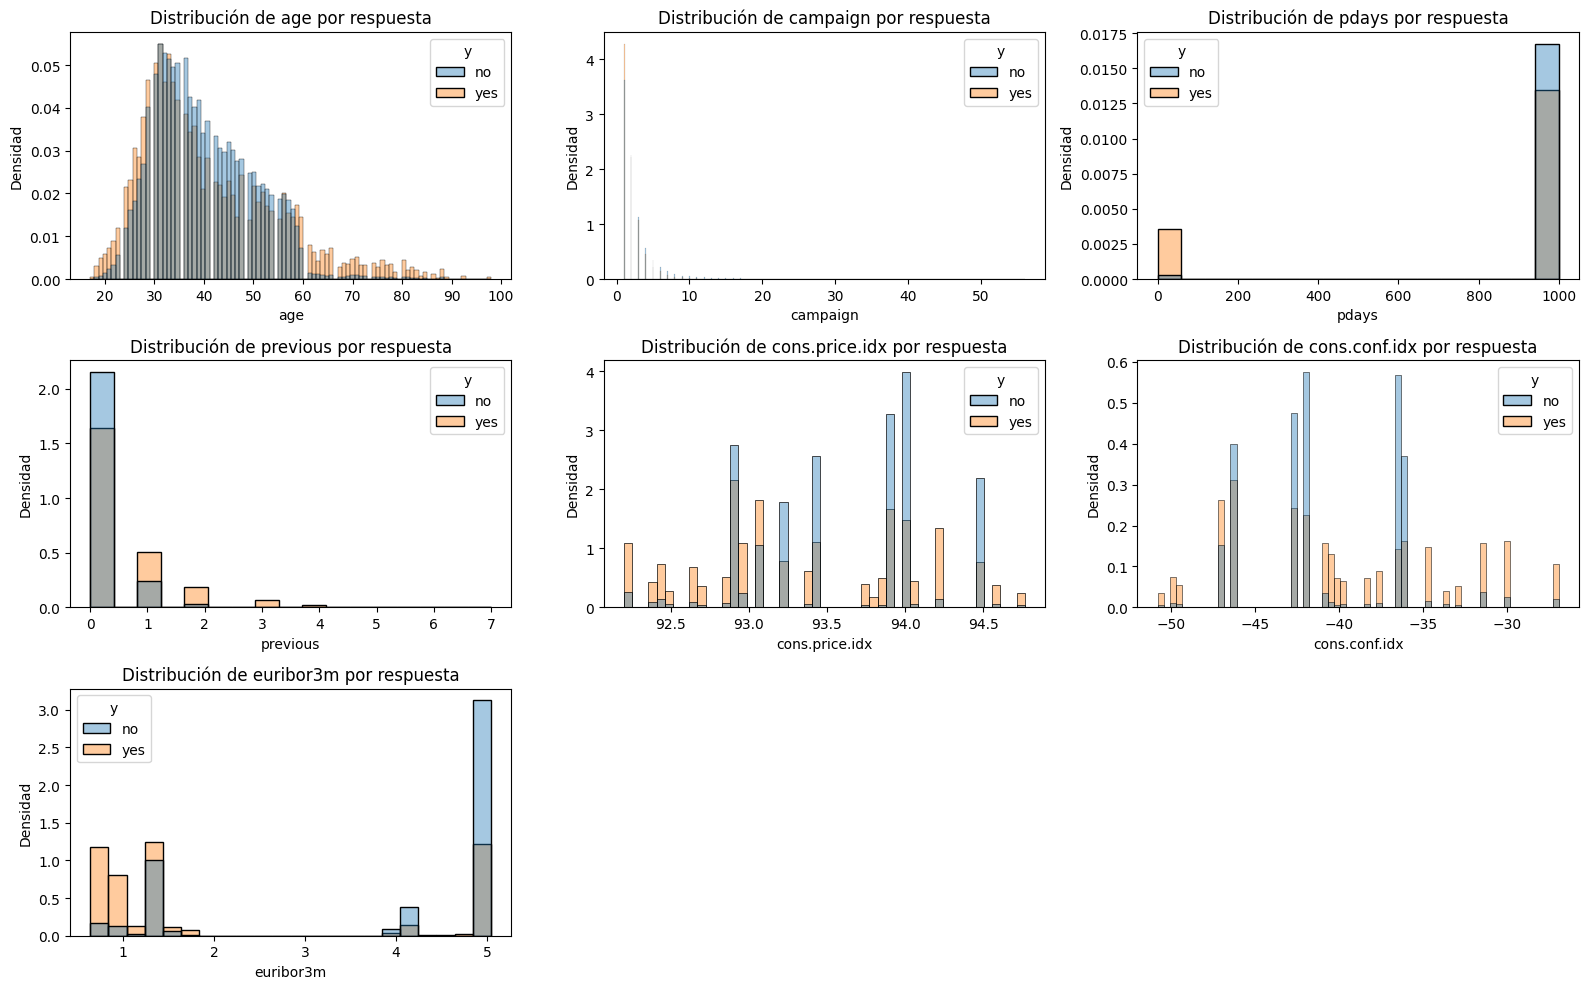

In [380]:
num_vars = ["age", "campaign", "pdays", "previous", "cons.price.idx", "cons.conf.idx", "euribor3m"]

fig, axes = plt.subplots(3, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    ax = axes[i]
    sns.histplot(
        data=df_eda,
        x=col,
        hue="y",             # 'yes' / 'no'
        stat="density",
        common_norm=False,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f"Distribución de {col} por respuesta")
    ax.set_xlabel(col)
    ax.set_ylabel("Densidad")

# Elimina ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


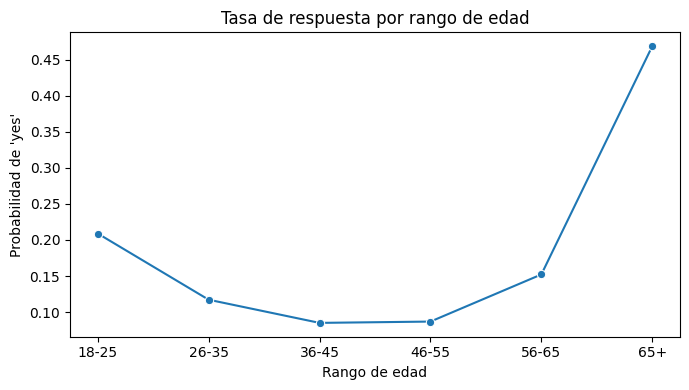

In [381]:
total_data["age_bin"] = pd.cut(total_data["age"],
                           bins=[17, 25, 35, 45, 55, 65, 100],
                           labels=["18-25", "26-35", "36-45", "46-55", "56-65", "65+"])

age_rate = (
    total_data.groupby("age_bin")["y_n"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(7, 4))
sns.lineplot(data=age_rate, x="age_bin", y="y_n", marker="o")
plt.title("Tasa de respuesta por rango de edad")
plt.xlabel("Rango de edad")
plt.ylabel("Probabilidad de 'yes'")
plt.tight_layout()
plt.show()

### 4.2 Relación entre "y" y variables categoricas

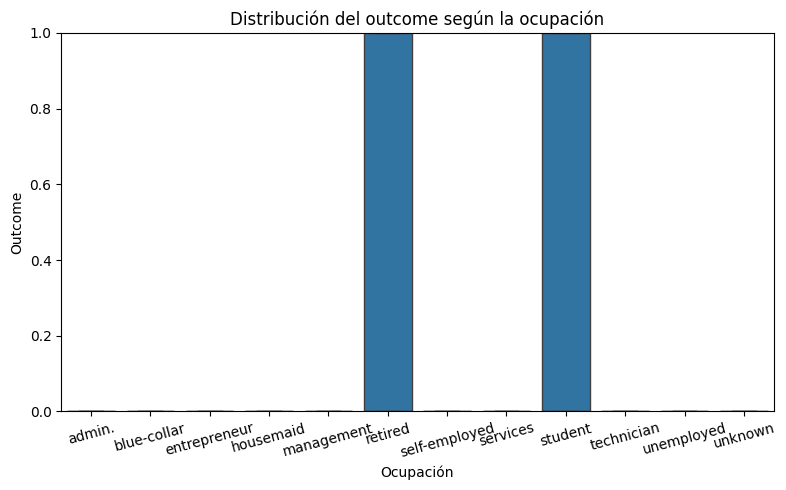

In [382]:
plt.figure(figsize=(8, 5))

order = total_data.groupby('job')['y_n'].median().sort_values().index
y_max = np.percentile(total_data['y_n'], 95)  # limitar eje Y

sns.boxplot(
    data=total_data,
    x='job',
    y='y_n',
    order=order,
    showfliers=False
)

plt.ylim(0, y_max)
plt.title("Distribución del outcome según la ocupación")
plt.xlabel("Ocupación")
plt.ylabel("Outcome")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

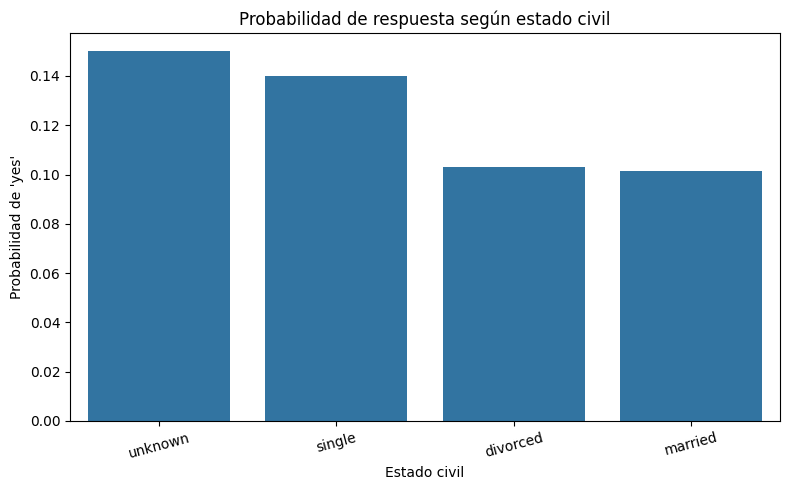

In [383]:
plt.figure(figsize=(8, 5))

marital_rate = (total_data.groupby('marital')['y_n'].mean().sort_values(ascending=False).reset_index())

sns.barplot(
    data=marital_rate,
    x='marital',
    y='y_n'
)

plt.title("Probabilidad de respuesta según estado civil")
plt.ylabel("Probabilidad de 'yes'")
plt.xlabel("Estado civil")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

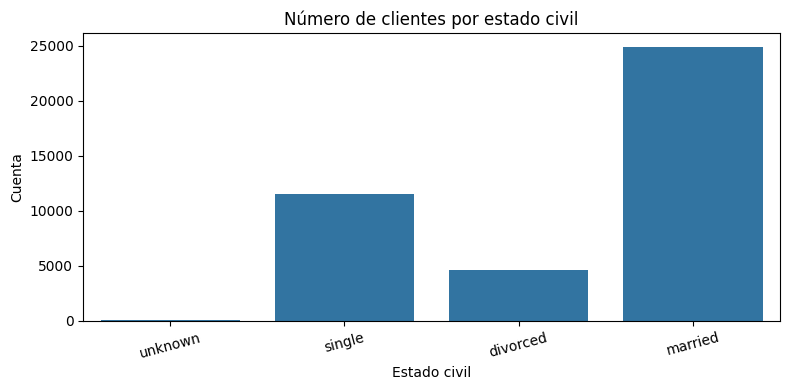

In [384]:
plt.figure(figsize=(8, 4))
sns.countplot(data=total_data, x="marital", order=marital_rate["marital"])
plt.title("Número de clientes por estado civil")
plt.xlabel("Estado civil")
plt.ylabel("Cuenta")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

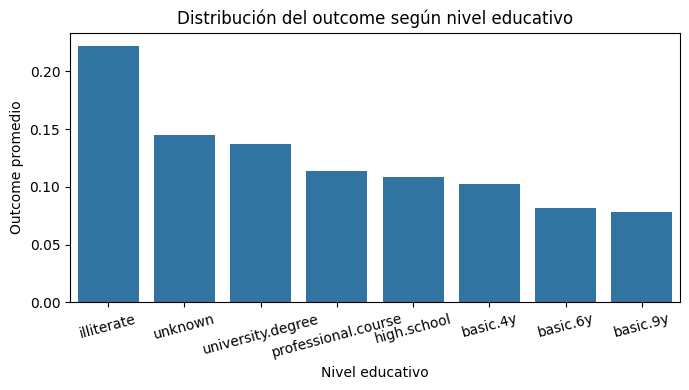

In [385]:
plt.figure(figsize=(7, 4))

education = (
    total_data.groupby('education')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=education,
    x='education',
    y='y_n'
)

plt.title("Distribución del outcome según nivel educativo")
plt.ylabel("Outcome promedio")
plt.xlabel("Nivel educativo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

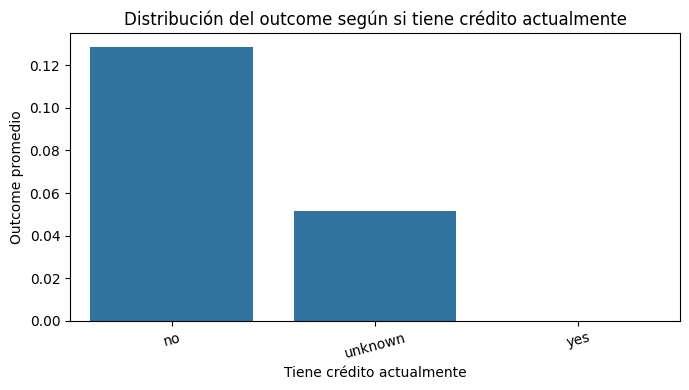

In [386]:
plt.figure(figsize=(7, 4))

default = (
    total_data.groupby('default')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=default,
    x='default',
    y='y_n'
)

plt.title("Distribución del outcome según si tiene crédito actualmente")
plt.ylabel("Outcome promedio")
plt.xlabel("Tiene crédito actualmente")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

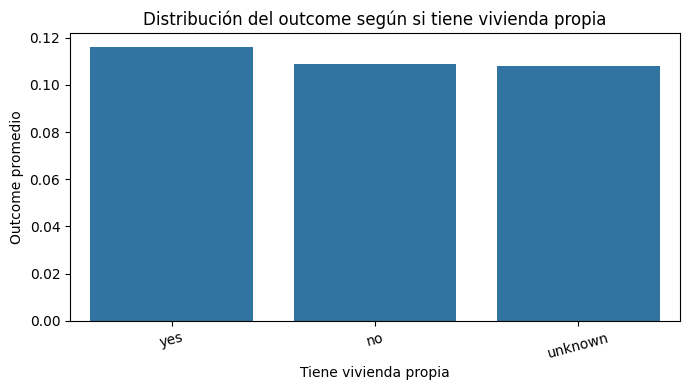

In [387]:
plt.figure(figsize=(7, 4))

housing = (
    total_data.groupby('housing')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=housing,
    x='housing',
    y='y_n'
)

plt.title("Distribución del outcome según si tiene vivienda propia")
plt.ylabel("Outcome promedio")
plt.xlabel("Tiene vivienda propia")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

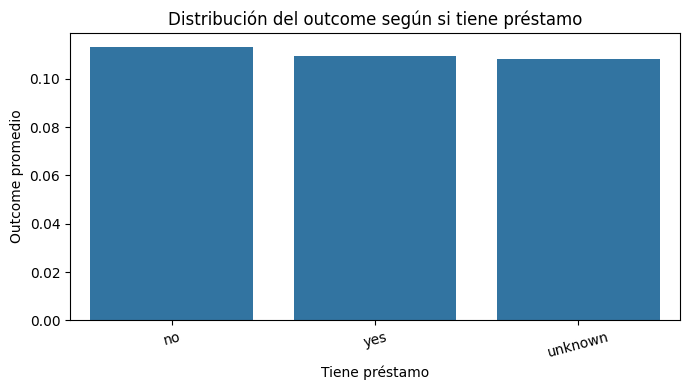

In [388]:
plt.figure(figsize=(7, 4))

loan = (
    total_data.groupby('loan')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=loan,
    x='loan',
    y='y_n'
)

plt.title("Distribución del outcome según si tiene préstamo")
plt.ylabel("Outcome promedio")
plt.xlabel("Tiene préstamo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

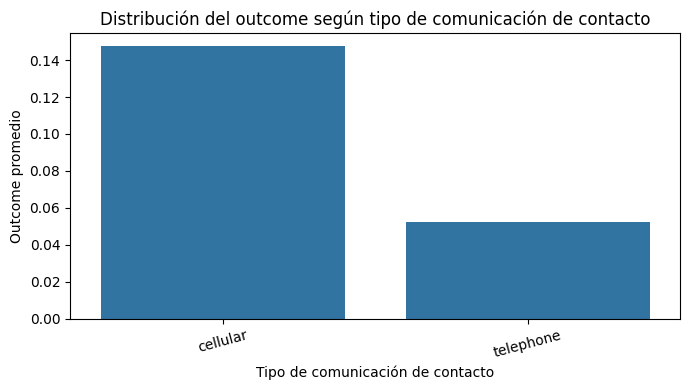

In [389]:
plt.figure(figsize=(7, 4))

contact = (
    total_data.groupby('contact')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=contact,
    x='contact',
    y='y_n'
)

plt.title("Distribución del outcome según tipo de comunicación de contacto")
plt.ylabel("Outcome promedio")
plt.xlabel("Tipo de comunicación de contacto")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

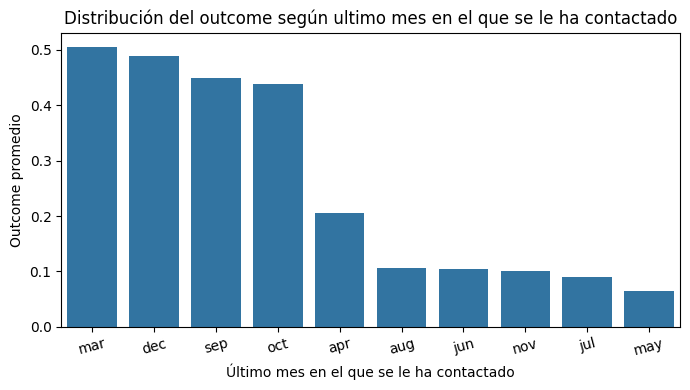

In [390]:
plt.figure(figsize=(7, 4))

month = (
    total_data.groupby('month')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=month,
    x='month',
    y='y_n'
)

plt.title("Distribución del outcome según ultimo mes en el que se le ha contactado")
plt.ylabel("Outcome promedio")
plt.xlabel("Último mes en el que se le ha contactado")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

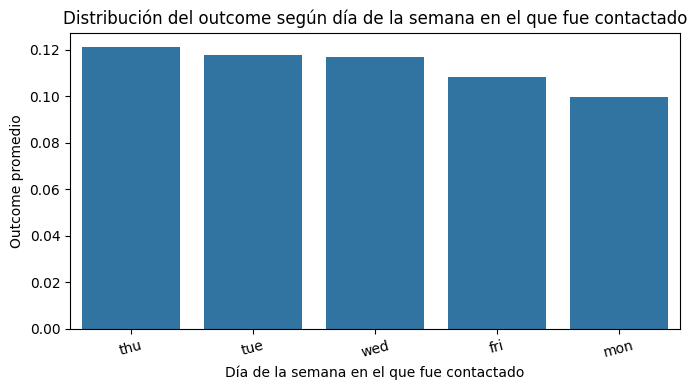

In [391]:
plt.figure(figsize=(7, 4))

day_of_week = (
    total_data.groupby('day_of_week')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=day_of_week,
    x='day_of_week',
    y='y_n'
)

plt.title("Distribución del outcome según día de la semana en el que fue contactado")
plt.ylabel("Outcome promedio")
plt.xlabel("Día de la semana en el que fue contactado")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

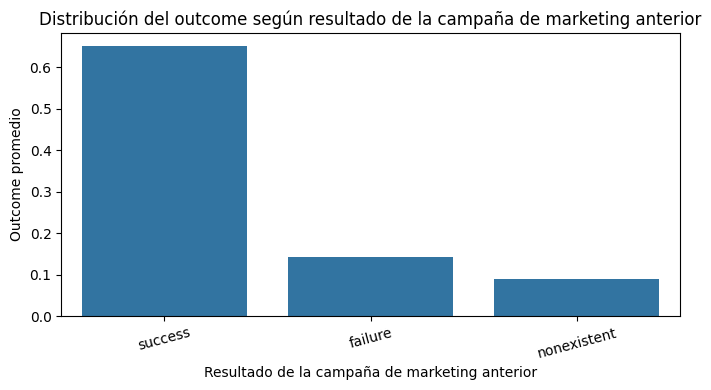

In [392]:
plt.figure(figsize=(7, 4))

poutcome = (
    total_data.groupby('poutcome')['y_n']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(
    data=poutcome,
    x='poutcome',
    y='y_n'
)

plt.title("Distribución del outcome según resultado de la campaña de marketing anterior")
plt.ylabel("Outcome promedio")
plt.xlabel("Resultado de la campaña de marketing anterior")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [393]:
pd.crosstab(total_data["poutcome"], total_data["y"], normalize="index")

y,no,yes
poutcome,,
failure,0.857714,0.142286
nonexistent,0.911678,0.088322
success,0.348871,0.651129


In [394]:
# Distribución de la variable objetivo

total_data["y"].value_counts(normalize=False)

total_data["y"].value_counts(normalize=True) * 100

y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

### 4.3 Mapa de correlacion de variables

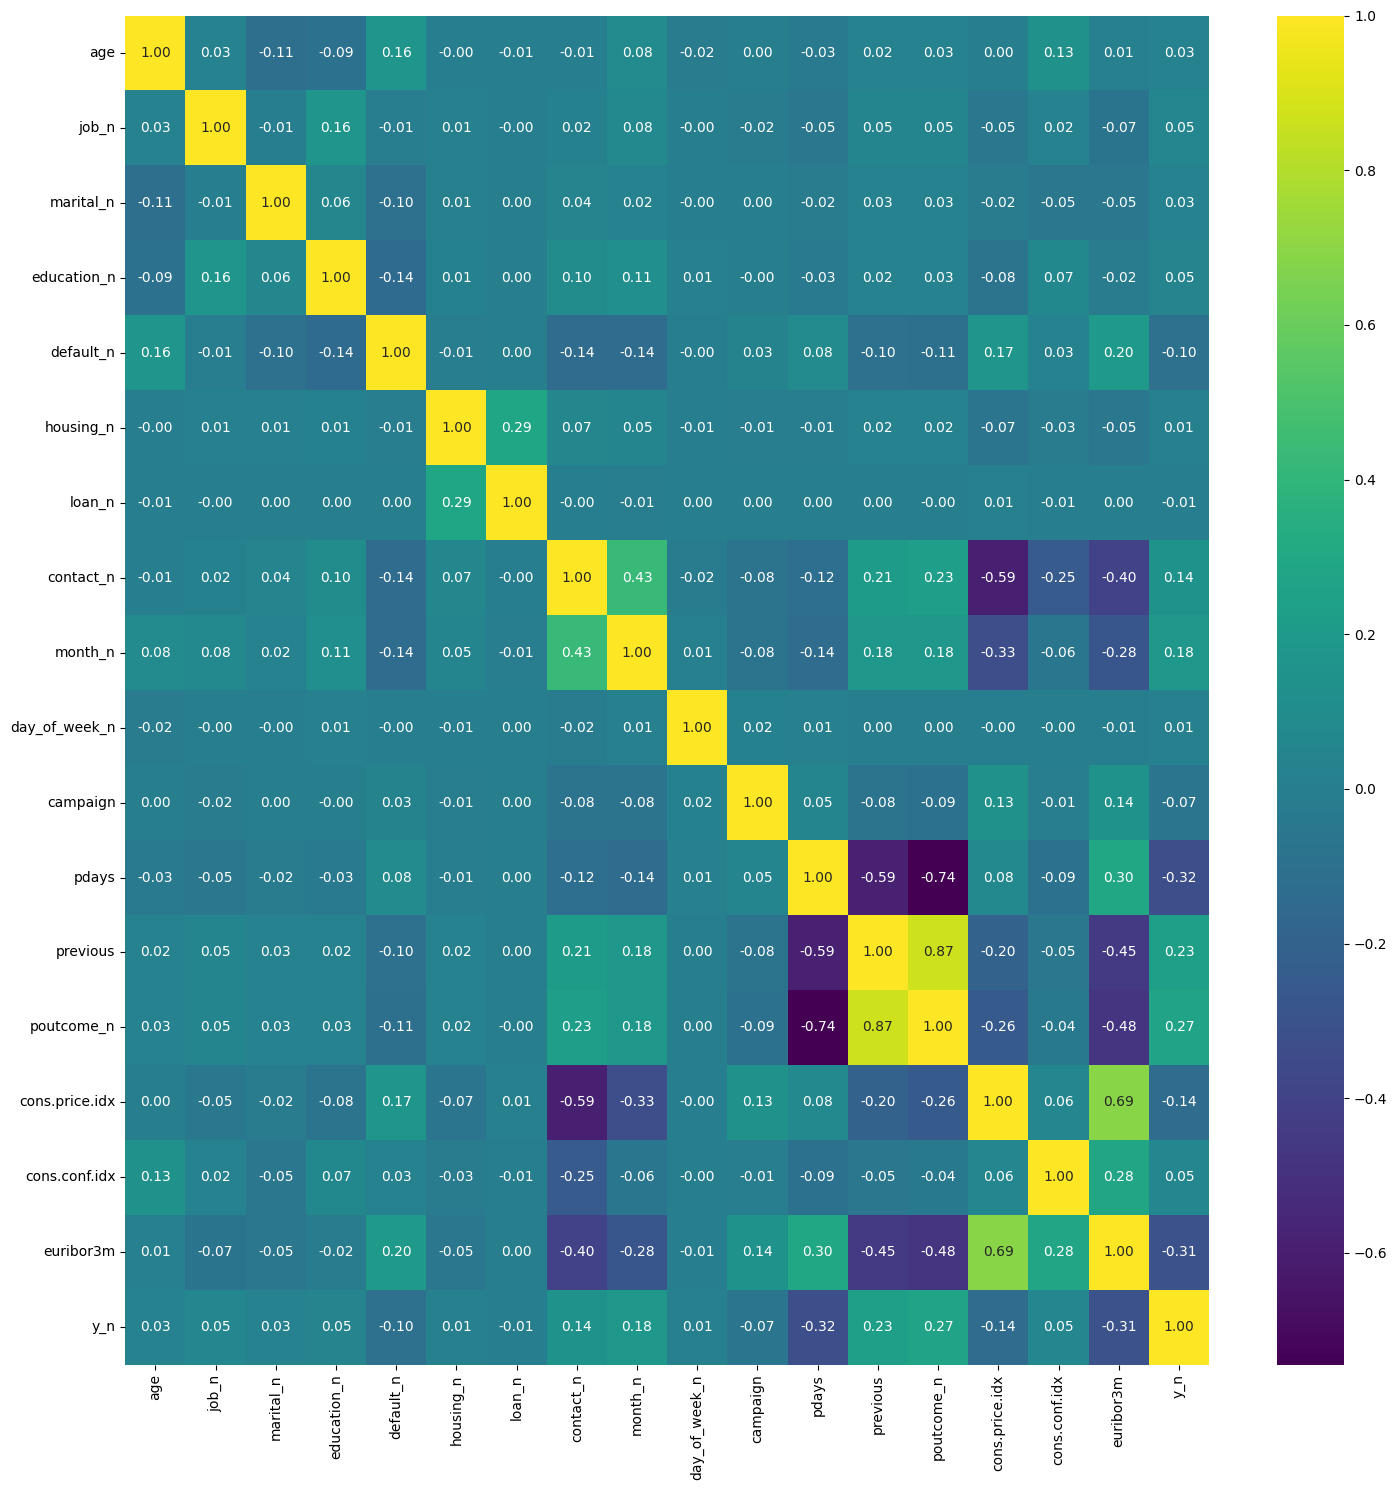

In [395]:
cols_num=["age","job_n","marital_n","education_n","default_n","housing_n","loan_n","contact_n","month_n",  
        "day_of_week_n","campaign","pdays","previous","poutcome_n","cons.price.idx",
        "cons.conf.idx","euribor3m","y_n"]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(total_data[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

### 4.4 Análisis de outliers

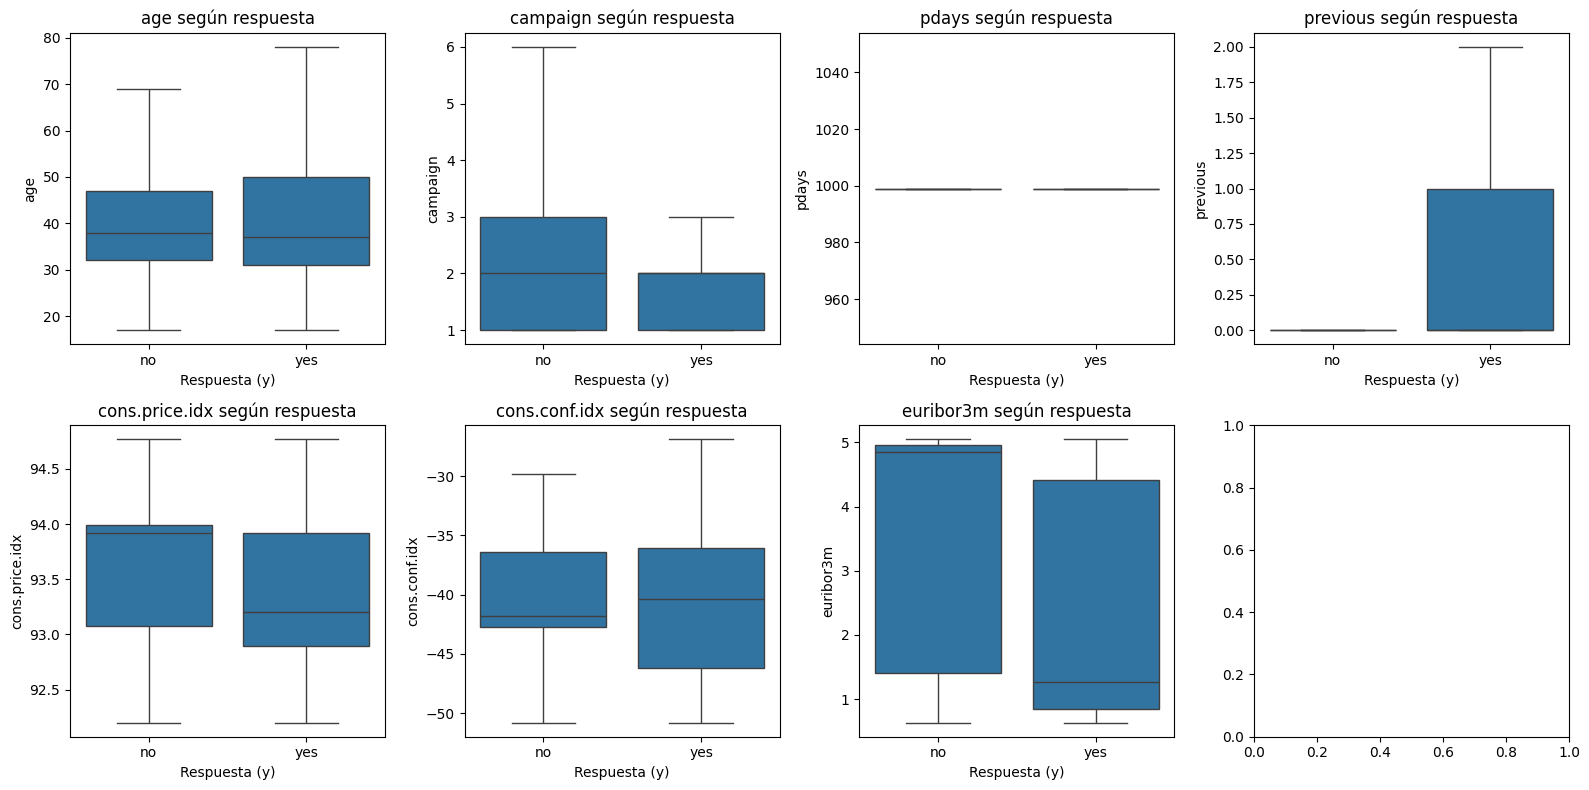

In [ ]:
outliers_cols = ["age", "campaign", "pdays", "previous", "cons.price.idx", "cons.conf.idx", "euribor3m"]

# Crear una grilla con suficientes ejes (2x4 = 8) para albergar las 7 variables
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(outliers_cols):
    sns.boxplot(
        data=total_data,
        x="y",
        y=col,
        ax=axes[i],
        showfliers=False
    )
    axes[i].set_title(f"{col} según respuesta")
    axes[i].set_xlabel("Respuesta (y)")
    axes[i].set_ylabel(col)

fig.delaxes(axes[7])  # Eliminar el último eje vacío

plt.tight_layout()
plt.show()

## 5. Preparación de los datos para el modelado

Para entrenar el modelo de Regresión Logística:

1. Definimos la variable objetivo `y` como un indicador binario (`1` = "yes", `0` = "no").
2. Separamos los datos en conjuntos de entrenamiento y prueba (`train_test_split`) con estratificación según `y`,
   para mantener la proporción de clases.
3. Aplicamos **one-hot encoding** a las variables categóricas mediante `pd.get_dummies`.
4. Escalamos las variables numéricas con `StandardScaler`, ya que la Regresión Logística es sensible a la escala
   de las features.

Este proceso nos deja una matriz de características numéricas lista para ser utilizada por el modelo.

In [397]:
#  Preparación del dataframe para modelado

total_data_CON_outliers = total_data.copy()
total_data_SIN_outliers = total_data.copy() # Lo vamos a modificar. Para cada variable con outliers, reemplazamos sus valores outliers


In [398]:
total_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_n,job_n,education_n,marital_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654,3.673691,3.277532,0.510634,0.208872,0.571914,0.199767,0.634748,2.250097,1.979581,0.169904
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173,2.454116,2.185525,0.696779,0.406686,0.541209,0.456002,0.481507,2.429079,1.411514,0.455754
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000,4.000000,6.000000,1.000000,0.000000,1.000000,0.000000,1.000000,3.000000,3.000000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000,11.000000,7.000000,3.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,2.000000


1. Age: Rango de edad esperado con outliers de gente mayor de 47
2. Campaign: Se contactó poco al cliente en la campaña siendo el 75% menor de 3 veces.
3. pdays: La mayoria no fue contactado en la campaña anterior (muy cercana a 1000 dias)
4. previous: Pocos contactos en la campaña anterior.

In [399]:
# **Funcion que devuelve el dataframe sin los outliers y los limites de los features**

def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [400]:
def replace_outliers(column, df):
  col_stats = df[column].describe()
  col_iqr = col_stats["75%"] - col_stats["25%"]
  upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
  lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

  if lower_limit < 0: lower_limit = min(df[column])
  # Vamos a quitar los outliers superiores
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Vamos a quitar los outliers inferiores
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}

for column in outliers_cols:
  total_data_SIN_outliers, limits = replace_outliers(column, total_data_SIN_outliers)
  outliers_dict.update({column: limits})

with open("../data/processed/outliers_dict.json", "w") as f:
  json.dump(outliers_dict, f)

### 5.1 Valores faltantes

En este apartado procedemos con el analisis de los valores nulos y los reemplazariamos con la media, mediana o moda, sin embargo al no contener nulos, seguimos con el analisis

In [401]:
print(total_data_CON_outliers.isnull().sum().sort_values(ascending=False))
total_data_SIN_outliers.isnull().sum().sort_values(ascending=False)

age_bin           5
age               0
job               0
education         0
marital           0
housing           0
loan              0
contact           0
default           0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
month             0
cons.price.idx    0
cons.conf.idx     0
nr.employed       0
euribor3m         0
y_n               0
job_n             0
education_n       0
y                 0
marital_n         0
default_n         0
loan_n            0
housing_n         0
contact_n         0
month_n           0
day_of_week_n     0
poutcome_n        0
dtype: int64


age_bin           5
age               0
job               0
education         0
marital           0
housing           0
loan              0
contact           0
default           0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
month             0
cons.price.idx    0
cons.conf.idx     0
nr.employed       0
euribor3m         0
y_n               0
job_n             0
education_n       0
y                 0
marital_n         0
default_n         0
loan_n            0
housing_n         0
contact_n         0
month_n           0
day_of_week_n     0
poutcome_n        0
dtype: int64

### 5.2 Escalado de valores

In [402]:
# Features

cols_num=["age","job_n","marital_n","education_n","default_n","housing_n","loan_n","contact_n","month_n",  
        "day_of_week_n","campaign","pdays","previous","poutcome_n","cons.price.idx",
        "cons.conf.idx","euribor3m"]

predictoras =cols_num[:-1]
target = "y_n"

X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 10)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 10)

In [403]:
# X_train_CON_outliers
# X_train_SIN_outliers

# X_test_CON_outliers
# X_test_SIN_outliers

# Guardamos 3 situaciones: 1- Dataset raw, 2- Dataset normalizado, 3- Dataset min-max escalado. Para cada una de estas situaciones, guardamos una versión con outliers y otra sin outliers.

## NORMALIZACIÓN

### CON OUTLIERS

norm_CON_outliers = StandardScaler()

norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


## ESCALADO MIN-MAX (MINMAXIMIZACIÓN)

### CON OUTLIERS
scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)


# GUARDADO DE LOS DATASETS RESULTANTES
X_train_CON_outliers.to_csv("../data/processed/X_train_CON_outliers.csv", index = False)
X_train_CON_outliers_norm.to_csv("../data/processed/X_train_CON_outliers_norm.csv", index = False)
X_train_CON_outliers_scal.to_csv("../data/processed/X_train_CON_outliers_scal.csv", index = False)
X_train_SIN_outliers.to_csv("../data/processed/X_train_SIN_outliers.csv", index = False)
X_train_SIN_outliers_norm.to_csv("../data/processed/X_train_SIN_outliers_norm.csv", index = False)
X_train_SIN_outliers_scal.to_csv("../data/processed/X_train_SIN_outliers_scal.csv", index = False)

X_test_CON_outliers.to_csv("../data/processed/X_test_CON_outliers.csv", index = False)
X_test_CON_outliers_norm.to_csv("../data/processed/X_test_CON_outliers_norm.csv", index = False)
X_test_CON_outliers_scal.to_csv("../data/processed/X_test_CON_outliers_scal.csv", index = False)
X_test_SIN_outliers.to_csv("../data/processed/X_test_SIN_outliers.csv", index = False)
X_test_SIN_outliers_norm.to_csv("../data/processed/X_test_SIN_outliers_norm.csv", index = False)
X_test_SIN_outliers_scal.to_csv("../data/processed/X_test_SIN_outliers_scal.csv", index = False)

y_train.to_csv("../data/processed/y_train.csv", index = False)
y_test.to_csv("../data/processed/y_test.csv", index = False)

# SCALERS

with open("../models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("../models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("../models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("../models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)

## 6. Selección de características

La selección de características (feature selection) es un proceso que implica seleccionar las características (variables) más relevantes de nuestro conjunto de datos para usarlas en la construcción de un modelo de Machine Learning, desechando el resto.

Existen varias razones para incluirlo en nuestro análisis exploratorio:

Simplificar el modelo para que sea más fácil de entender e interpretar.
Reducir el tiempo de entrenamiento del modelo.
Evitar el sobre ajuste al reducir la dimensionalidad del modelo y minimizar el ruido y las correlaciones innecesarias.
Mejorar el rendimiento del modelo al eliminar las características irrelevantes.
La librería sklearn contiene gran parte de las mejores alternativas para llevarla a cabo. Una de las herramientas que más se utilizan para realizar procesos de selección de características rápidos y con buenos resultados es SelectKBest. Esta función selecciona las k mejores características de nuestro conjunto de datos basándose en una función de un test estadístico. Este test estadístico normalmente es un ANOVA o un Chi-Cuadrado:

In [404]:
X_train = X_train_CON_outliers.copy()
X_test = X_test_CON_outliers.copy()

# Con un valor de k = 5 decimos implícitamente que queremos eliminar 2 características del conjunto de datos
selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

,contact_n,month_n,pdays,previous,poutcome_n
0,0.0,0.0,999.0,0.0,0.0
1,0.0,0.0,999.0,0.0,0.0
2,1.0,0.0,999.0,1.0,1.0
3,1.0,8.0,999.0,0.0,0.0
4,1.0,2.0,999.0,0.0,0.0


# Proceso de Machine Learning

## 7. Seleccion del mejor dataset

In [405]:
datasets = [
    X_train_CON_outliers,
    X_train_CON_outliers_norm,
    X_train_CON_outliers_scal,
    X_train_SIN_outliers,
    X_train_SIN_outliers_norm,
    X_train_SIN_outliers_scal
]
dataset_names = [
    "X_train_CON_outliers",
    "X_train_CON_outliers_norm",
    "X_train_CON_outliers_scal",
    "X_train_SIN_outliers",
    "X_train_SIN_outliers_norm",
    "X_train_SIN_outliers_scal"]

models = []
accs = []
for i,dataset in enumerate(datasets):
  model = LogisticRegression(random_state=10, solver='lbfgs', max_iter=400) # Regresión Logística
  model.fit(dataset, y_train) # Entreno el modelo
  y_pred = model.predict(dataset)
  acc = accuracy_score(y_train, y_pred)
  accs.append(acc)
  models.append(model)
  print(f"Accuracy del dataset {i}: {acc:.4f}")

best_acc = max(accs)
best_index = accs.index(best_acc)

print(f"\nEl mejor dataset es el dataset {best_index}, es decir, {dataset_names[best_index]} con accuracy = {best_acc:.4f}")

Accuracy del dataset 0: 0.8990
Accuracy del dataset 1: 0.8987
Accuracy del dataset 2: 0.8984
Accuracy del dataset 3: 0.8947
Accuracy del dataset 4: 0.8941
Accuracy del dataset 5: 0.8941

El mejor dataset es el dataset 0, es decir, X_train_CON_outliers con accuracy = 0.8990


## 8. Entrenamiento y evaluación del modelo de Regresión Logística

Entrenamos un modelo base de Regresión Logística con los datos preparados y evaluamos su rendimiento en el
conjunto de prueba.

Las métricas que analizamos son:

- **Accuracy**: proporción de aciertos totales.
- **Matriz de confusión**: distribución de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
- **Precision, Recall y F1-score** para cada clase (especialmente la clase positiva "yes").

Posteriormente utilizamos `GridSearchCV` para ajustar hiperparámetros clave (como `C`, `penalty` y `class_weight`)
y seleccionamos el mejor modelo según validación cruzada.

### 8.1 Optimización de hiperparámetros para mejorar el modelo lo más posible

In [406]:
params = {
    "l1_ratio": [0, 0.5, 1],
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1", "l2", "elasticnet", None],
    "dual": [True,False],
    "tol":[0.1, 0.0001, 0.000001],
    "fit_intercept": [True, False],
#    "intercept_scaling":[1, 10, 20, 50],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 200, 400]
}

#### 8.1.1 Grid Search - "Estrategia forzosa"

In [ ]:
grid = GridSearchCV(LogisticRegression(random_state=10), params, scoring="accuracy", n_jobs = -1)
grid.fit(datasets[best_index], y_train)
print("Mejores parámetros: ", grid.best_params_)
best_model = grid.best_estimator_
print("Mejor estimador: ", best_model)
print("Mejor puntuación: ", grid.best_score_)

#### 8.1.2 Random search - "Estrategia aleatoria"

In [ ]:
grid = RandomizedSearchCV(LogisticRegression(random_state=10, solver='lbfgs', max_iter=400), params, scoring="accuracy", n_iter = 30, n_jobs = -1)
grid.fit(datasets[best_index], y_train)
print("Mejores parámetros: ", grid.best_params_)
best_model = grid.best_estimator_
print("Mejor estimador: ", best_model)
print("Mejor puntuación: ", grid.best_score_)

Los mejores parámetros son:  {'tol': 1e-06, 'solver': 'liblinear', 'max_iter': 400, 'l1_ratio': 0, 'fit_intercept': True, 'dual': True, 'C': 1.0}
El mejor estimador es:  LogisticRegression(dual=True, l1_ratio=0, max_iter=400, random_state=10,
                   solver='liblinear', tol=1e-06)
La mejor puntuación es:  0.898421851289833


### 8.2 Metricas con hiperparametros optimizados

In [ ]:
X_test_CON_outliers = pd.read_csv("../data/processed/X_test_CON_outliers.csv")
X_test_CON_outliers_norm = pd.read_csv("../data/processed/X_test_CON_outliers_norm.csv")
X_test_CON_outliers_scal = pd.read_csv("../data/processed/X_test_CON_outliers_scal.csv")
X_test_SIN_outliers = pd.read_csv("../data/processed/X_test_SIN_outliers.csv")
X_test_SIN_outliers_norm = pd.read_csv("../data/processed/X_test_SIN_outliers_norm.csv")
X_test_SIN_outliers_scal = pd.read_csv("../data/processed/X_test_SIN_outliers_scal.csv")

y_test = pd.read_csv("../data/processed/y_test.csv")
y_test = y_test.squeeze()

datasets_test = [X_test_CON_outliers,
    X_test_CON_outliers_norm,
    X_test_CON_outliers_scal,
    X_test_SIN_outliers,
    X_test_SIN_outliers_norm,
    X_test_SIN_outliers_scal
    ]


model_f = LogisticRegression(C=0.1, l1_ratio=1, random_state=10, solver='liblinear',
                   tol=0.1)
model_f.fit(datasets[best_index], y_train) #en vez de model_f se podria utilizar best_model ya que esa variable es la que contiene el modelo entrenado de gridSearch con lo hiperparametros optimizados

y_pred = model_f.predict(datasets[best_index])
metric_train = accuracy_score(y_train, y_pred)

y_pred = model_f.predict(datasets_test[best_index])
metric_test = accuracy_score(y_test, y_pred)


print(f"La mejor métrica de nuestros datasets x_train son: {metric_train} y los x_test son: {metric_test}")

La mejor métrica de nuestros datasets x_train son: 0.8987556904400607 y los x_test son: 0.8951201747997086
